<a href="https://colab.research.google.com/github/Mahshid-git/Emotions/blob/main/02_Model/Modeling_Tfid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/content/drive")
%cd '/content/drive/MyDrive/Emotions/'

Mounted at /content/drive
/content/drive/MyDrive/Emotions


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('clean_text_final.csv')
data = data[['text', 'label', 'clean_text']]
data.tail()

,text,label,clean_text
416788,i feel like telling these horny devils to find...,2,feel like tell horny devil find site suit sort...
416789,i began to realize that when i was feeling agi...,3,begin realize feel agitate restless think go dish
416790,i feel very curious be why previous early dawn...,5,feel curious previous early dawn time seek tro...
416791,i feel that becuase of the tyranical nature of...,3,feel because tyrannical nature government el s...
416792,i think that after i had spent some time inves...,5,think spend time investigate surround things s...


In [10]:
data['clean_text'].apply(lambda x: len(x.split(' '))).sum()

3779979

After text cleaning and removing stop words, we have about 3.8 million words to work with!

In [15]:
X = data['clean_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 1) Multinomial Naive Bayes Classification

In [46]:
''' TfidfTransformer transforms a count matrix to a normalized tf or tf-idf representation.
 Tf means term-frequency while tf-idf means term-frequency times inverse
 document-frequency. This is a common term weighting scheme in information retrieval,
 that has also found good use in document classification.'''
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [18]:
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

class_to_emotion = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
emotions = class_to_emotion.values()
print(classification_report(y_test, y_pred,target_names=emotions))

accuracy 0.7774930661522663
              precision    recall  f1-score   support

     sadness       0.78      0.94      0.85     30296
         joy       0.71      0.97      0.82     35266
        love       0.95      0.27      0.41      8639
       anger       0.93      0.65      0.77     14328
        fear       0.90      0.55      0.68     11927
    surprise       0.95      0.09      0.17      3743

    accuracy                           0.78    104199
   macro avg       0.87      0.58      0.62    104199
weighted avg       0.81      0.78      0.75    104199



In [23]:
cm =confusion_matrix(y_test, y_pred)

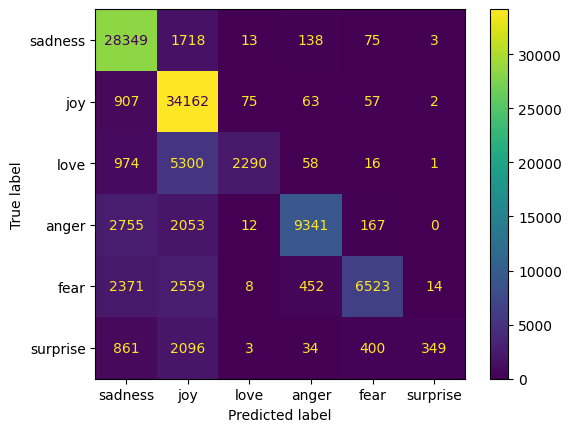

In [27]:
disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
disp.plot()

In [45]:
# per class accuracy
per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))

Accuracy of Class 0 (sadness): 0.9357
Accuracy of Class 1 (joy): 0.9687
Accuracy of Class 2 (love): 0.2651
Accuracy of Class 3 (anger): 0.6519
Accuracy of Class 4 (fear): 0.5469
Accuracy of Class 5 (surprise): 0.0932


As expected surprise and love that have the smallest class are showing the lowest accuracy.

# 2) Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=emotions))

accuracy 0.8864480465263582
              precision    recall  f1-score   support

     sadness       0.93      0.93      0.93     30296
         joy       0.91      0.92      0.91     35266
        love       0.78      0.73      0.76      8639
       anger       0.89      0.89      0.89     14328
        fear       0.84      0.84      0.84     11927
    surprise       0.74      0.68      0.71      3743

    accuracy                           0.89    104199
   macro avg       0.85      0.83      0.84    104199
weighted avg       0.89      0.89      0.89    104199



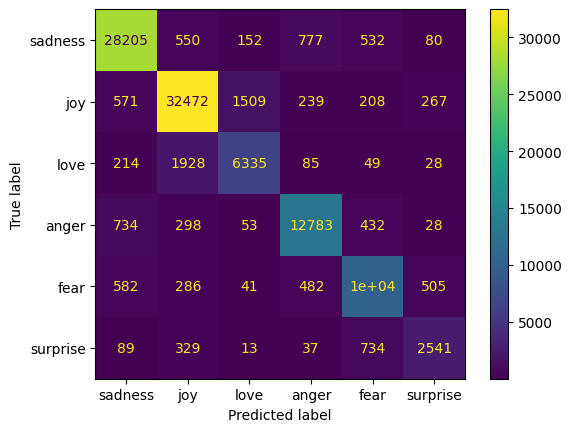

In [49]:
cm =confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
disp.plot()

In [50]:
# per class accuracy
per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))

Accuracy of Class 0 (sadness): 0.9310
Accuracy of Class 1 (joy): 0.9208
Accuracy of Class 2 (love): 0.7333
Accuracy of Class 3 (anger): 0.8922
Accuracy of Class 4 (fear): 0.8410
Accuracy of Class 5 (surprise): 0.6789


The results are way better

# 3) SVM with SGD

In [52]:
from sklearn.linear_model import SGDClassifier

# linear
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=emotions))

accuracy 0.8579448939049319
              precision    recall  f1-score   support

     sadness       0.88      0.94      0.91     30296
         joy       0.81      0.96      0.88     35266
        love       0.95      0.45      0.61      8639
       anger       0.90      0.82      0.86     14328
        fear       0.88      0.77      0.82     11927
    surprise       0.86      0.59      0.70      3743

    accuracy                           0.86    104199
   macro avg       0.88      0.75      0.80    104199
weighted avg       0.87      0.86      0.85    104199



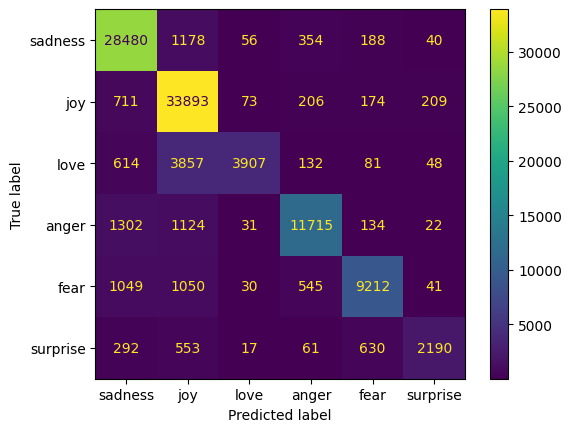

In [53]:
cm =confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
disp.plot()

In [54]:
# per class accuracy
per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))

Accuracy of Class 0 (sadness): 0.9401
Accuracy of Class 1 (joy): 0.9611
Accuracy of Class 2 (love): 0.4523
Accuracy of Class 3 (anger): 0.8176
Accuracy of Class 4 (fear): 0.7724
Accuracy of Class 5 (surprise): 0.5851


# 4) SVM with Kernel

In [ ]:
# since this is nonlinear (kernel=rbf) it takes longer than the rest of classifiers to run

from sklearn.svm import SVC

# with rbf kernel
svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(kernel='rbf', random_state=42, gamma='scale')),
               ])

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=emotions))

In [ ]:
cm =confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
disp.plot()

In [ ]:
# per class accuracy
per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))

# 5) KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=5, metric='cosine')),
               ]) # cosine metric is best for similarity in nlp

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=emotions))

In [ ]:
cm =confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
disp.plot()

In [ ]:
# per class accuracy
per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))